#<h1>Import Libraries</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd
import json
import sys
import os
import gc
import pickle
from nltk.stem.porter import PorterStemmer
import ast
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.feature_selection import SelectKBest, chi2
import re
import numpy as np
nltk.download('vader_lexicon')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# <h1>Initial Process</h1>

##<h1> Data Pre Processing </h1>




In [3]:

class data_set_pre_processing:

  def __init__(self):
    # Mentioning File Paths
    self.book_json_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/goodreads_books_children.json"
    self.userReview_json_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/goodreads_reviews_children.json"

    self.folder_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data"
    self.goodreads_books_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl"
    self.goodreads_books_pkl_raw_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children_raw.pkl"
    self.goodreads_reviews_children_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_reviews_children.pkl"
    self.book_df=None
    # Object Initialize For Stemminization Process (Swiming -> swim)
    self.ps=PorterStemmer()

  # To Create Test Folder to store our files
  def create_folder(self):
      if not os.path.exists(self.folder_path):
        os.makedirs(self.folder_path)

  # it will convert the authors column format
  def convert(self,obj):
    obj=str(obj)
    l=[]
    for i in ast.literal_eval(obj):
      l.append(i["author_id"])
    return " ".join(l)

  # to do the stemmation Process
  def stem(self,text):
    pattern = r'\b\d+\b'
    text_without_numbers = re.sub(pattern, '', text)
    words = word_tokenize(text_without_numbers)
    stemmed_words = [self.ps.stem(word) for word in words]
    return ' '.join(stemmed_words)



  #Transfer processed Book  data to pkl file
  def convert_books_data(self):
    with open( self.goodreads_books_pkl_path, "wb") as f:
      temp=[]
      # Reading the csv file in chunks
      for chunk in pd.read_json(self.book_json_path,lines=True,chunksize=10000):

        chunk["authors"]=chunk["authors"].apply(self.convert)
        chunk=chunk[chunk["language_code"]=="eng"]
        temp.append(chunk["book_id"])######
        chunk["description"]=chunk["description"].apply(self.stem)
        chunk["title"]=chunk["title"].apply(self.stem)
        chunk["publisher"]=chunk["publisher"].apply(self.stem)
        pickle.dump(chunk[['book_id','title','average_rating','authors','publisher', 'description']],f)

      self.book_df=pd.concat(temp,ignore_index=True)##########
      print("Books Data Processed")


  # Transfer raw Book Data data to pkl file
  def book_data(self):
    df=pd.read_json(self.book_json_path,lines=True)
    with open( self.goodreads_books_pkl_raw_path, "wb") as f:
      pickle.dump(df[df["language_code"]=="eng"],f)
    print("Raw Book Data Processed")

  # Transfer processed user review   data to pkl file
  def convert_user_review_data(self):
   with open( self.goodreads_reviews_children_pkl_path, "wb") as f:
    # Reading the csv file in chunks
      for chunk in pd.read_json(self.userReview_json_path,lines=True,chunksize=5000):
        chunk=chunk[chunk["book_id"].isin(self.book_df["book_id"])]
        pickle.dump(chunk[['user_id', 'book_id',"review_text"]],f)
      print("User Review  Data Processed")



  # All the Pre Processing Methods are called here
  def do_data_initialization(self):
    self.create_folder()
    print("Processing Book Dataset")
    self.convert_books_data()
    self.book_df=self.read_in_chunks()
    print("Processing User Review Dataset")
    self.convert_user_review_data()
    print("Processing Book Raw Data")
    self.book_data()


  # To Read the goodreads_books pickle file
  def read_in_chunks(self):
    chunks=[]
    with open( self.goodreads_books_pkl_path,'rb') as f:
      while True:
        try:
            chunks.append(pickle.load(f))
        except EOFError:
            break
    return pd.concat(chunks,ignore_index=True)


  # To Read the goodreads_reviews pickle file
  def get_user_data(self):
    chunks=[]
    with open( self.goodreads_reviews_children_pkl_path,'rb') as f:
      while True:
        try:
            chunks.append( pickle.load(f))
        except EOFError:
            break
    return pd.concat(chunks,ignore_index=True)


pre_processing=data_set_pre_processing()
pre_processing.do_data_initialization()

#pre_processing.read_in_chunks()

Processing Book Dataset
Books Data Processed
Processing User Review Dataset
User Review  Data Processed
Processing Book Raw Data
Raw Book Data Processed


In [4]:
# pre_processing.book_df.head(5)

BOOK Dataset

In [5]:
def read_in_chunks():
    chunks=[]
    with open( "/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl",'rb') as f:
      count=1
      while True:
        try:
            count+=1
            chunks.append( pickle.load(f))
        except EOFError:
            break
    print("count:",count)
    return pd.concat(chunks,ignore_index=True)

read_in_chunks()

count: 15


,book_id,title,average_rating,authors,publisher,description
0,89378,dog heaven,4.43,5411,blue ski press,in newberi medalist cynthia rylant 's classic ...
1,8037411,the saturday,4.14,3420,"henri holt & compani , inc .",meet the melendi ! the four melendi children l...
2,34680604,sir chocol and the sugar dough bee stori and c...,4.55,15584446 15584447,tsl public,a greedi snail damag the flower field and the ...
3,30199811,onli one,3.59,222111 4112701,scholast,"a novel count book , center around a counti fa..."
4,8307481,the blue cat of castl town,3.96,4601173,"longman , green and co .",
...,...,...,...,...,...,...
30248,25582830,beetl boy ( the battl of the beetl # ),4.15,14010953,the chicken hous,the gloriou start to a middle-grad trilog abou...
30249,10763390,if the world were a villag : a book about the ...,4.28,7503974 522607,kid can press,there are current more than six billion peopl ...
30250,13244380,let 's talk about cheat,4.06,77065 174068,grolier enterpris corp,help me be good about cheat encourag children ...
30251,25332059,ani fin is possibl ( my big fat zombi goldfish...,4.24,6863370 7008553,feiwel & friend,franki wa a complet normal pet goldfish ... un...


In [6]:
# pre_processing.read_in_chunks()

User's Review Dataset

In [7]:
pre_processing.get_user_data()

,user_id,book_id,review_text
0,8842281e1d1347389f2ab93d60773d4d,23310161,Fun sequel to the original.
1,8842281e1d1347389f2ab93d60773d4d,17290220,One of my favorite books to read to my 5 year ...
2,8842281e1d1347389f2ab93d60773d4d,460548,My daughter is loving this. Published in the 6...
3,8842281e1d1347389f2ab93d60773d4d,11474551,A friend sent me this. Hilarious!
4,8842281e1d1347389f2ab93d60773d4d,304889,One of my favorite books as a kid!
...,...,...,...
326029,11574a1bb25eb6b37e41d78407deba02,294442,The book that defined my teenage.
326030,05e9a93ad1dad3d48e445d6524b9724a,233818,http://www.softbound.blogspot.com/201... \n Sc...
326031,3eb86f798cfa3eeba658e92c32eff13d,6576481,I like this storyline quite a lot. I watched t...
326032,851c293f32e432b088f4ae521eb332e9,3636,I started this book and finished it within the...


## <h1>Exploratory Data Analysis</h1>

In [8]:
books_df = pre_processing.read_in_chunks()
reviews_df = pre_processing.get_user_data()

<ipython-input-9-87d7e6ae3e3e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_books = books_df.corr()


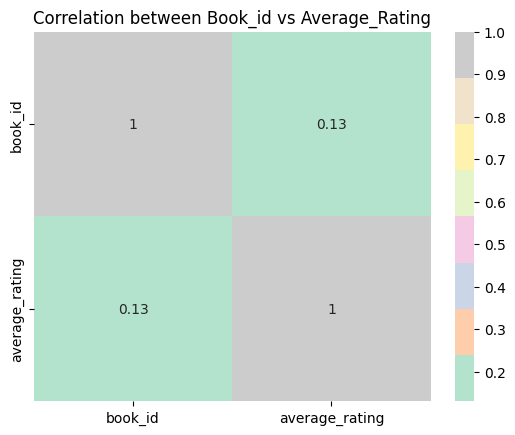

In [9]:
# Correlation between Book_id vs Average_Rating

correlation_books = books_df.corr()
sns.heatmap(correlation_books, annot=True,cmap='Pastel2')
plt.title('Correlation between Book_id vs Average_Rating')
plt.show()

### EDA IN BOOKDATA

In [10]:
books_df.columns

Index(['book_id', 'title', 'average_rating', 'authors', 'publisher',
       'description'],
      dtype='object')

In [11]:
books_df.shape

(30253, 6)

In [12]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30253 entries, 0 to 30252
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   book_id         30253 non-null  int64  
 1   title           30253 non-null  object 
 2   average_rating  30253 non-null  float64
 3   authors         30253 non-null  object 
 4   publisher       30253 non-null  object 
 5   description     30253 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ MB


In [13]:
books_df.describe()

,book_id,average_rating
count,3.025300e+04,30253.000000
mean,1.213530e+07,3.973210
std,1.058396e+07,0.349157
min,5.000000e+00,0.000000
25%,1.557040e+06,3.780000
50%,1.025611e+07,4.000000
75%,2.075012e+07,4.180000
max,3.646988e+07,5.000000


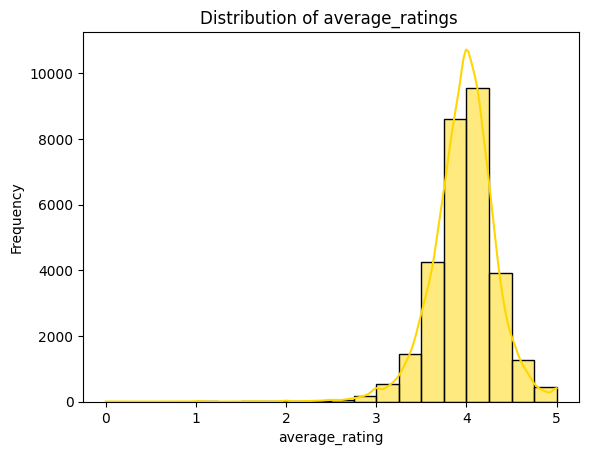

In [14]:
#Distribution of average_ratings

sns.histplot(books_df['average_rating'], bins=20, kde=True, color='gold')
plt.title('Distribution of average_ratings ')
plt.xlabel('average_rating')
plt.ylabel('Frequency')
plt.show()

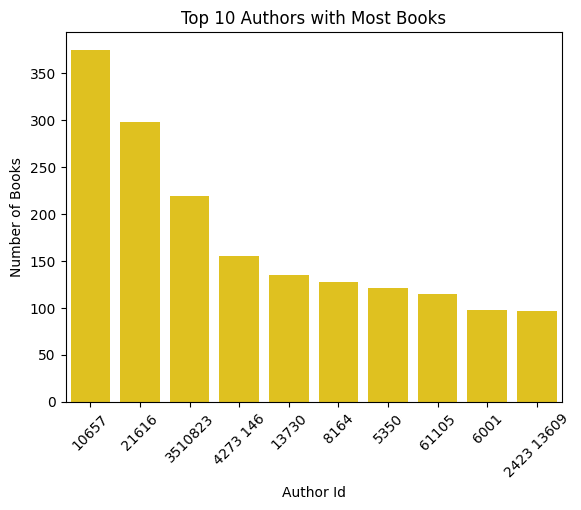

In [15]:
# Top 10 Authors with Most Books

sns.countplot(x='authors', data=books_df, order=books_df['authors'].value_counts().index[:10], color='#FFD700')
plt.title('Top 10 Authors with Most Books')
plt.xlabel('Author Id')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()

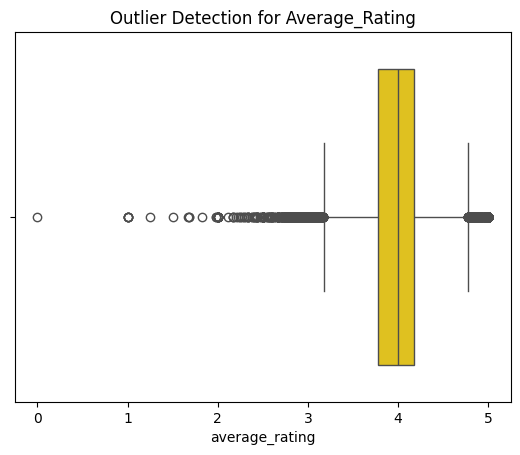

In [16]:
#Outlier Detection for Average_Rating

sns.boxplot(x='average_rating', data=books_df, color='#FFD700')
plt.title('Outlier Detection for Average_Rating')
plt.show()

### EDA IN REVIEWDATA

In [17]:
reviews_df.columns

Index(['user_id', 'book_id', 'review_text'], dtype='object')

In [18]:
reviews_df.shape

(326034, 3)

In [19]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326034 entries, 0 to 326033
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      326034 non-null  object
 1   book_id      326034 non-null  int64 
 2   review_text  326034 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.5+ MB


In [20]:
reviews_df.describe()

,book_id
count,3.260340e+05
mean,9.833578e+06
std,1.034411e+07
min,5.000000e+00
25%,1.911130e+05
50%,6.694791e+06
75%,1.805379e+07
max,3.646988e+07


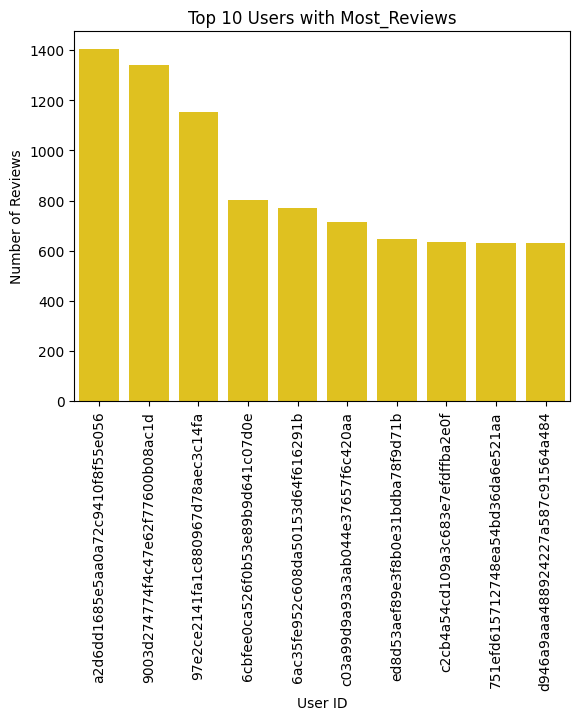

In [21]:
#Top 10 Users with Most_Reviews

sns.countplot(x='user_id', data=reviews_df, order=reviews_df['user_id'].value_counts().index[:10], color='#FFD700')
plt.title('Top 10 Users with Most_Reviews')
plt.xlabel('User ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation='vertical')
plt.show()

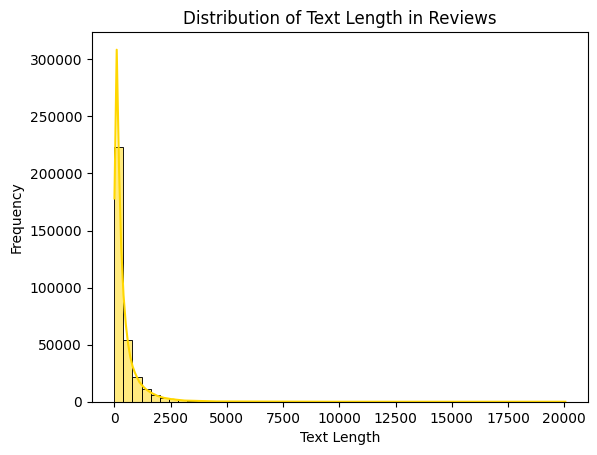

In [22]:
#Distribution of Text Length in Reviews
reviews_df['text_length'] = reviews_df['review_text'].apply(len)
sns.histplot(reviews_df['text_length'], bins=50, kde=True, color='#FFD700')
plt.title('Distribution of Text Length in Reviews')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()



##<h1>Item's Representation</h1>



### Using Term-Frequency Times Inverse Document-Frequency

In [23]:
class BookData_ItemRepresentation:
  def __init__(self):
    self.goodreads_books_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl"
    self.tfidf_vectorizer= TfidfVectorizer(stop_words='english',max_features =5000)
    self.BookData_ItemRepresentation_path = '/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation.pkl'

  def get_book_data(self):
    chunk_size = 5000
    json_reader = pd.read_json(self.Book_data_file_path, lines=True, chunksize=chunk_size)
    return json_reader

  def get_TfIdf_Vectorizer(self):
    book_data_list = []
    with open(self.goodreads_books_pkl_path,'rb') as f:
      while True:
        try:
          book_data_list.append(pickle.load(f))
        except EOFError:
            break

    book_data=pd.concat(book_data_list,ignore_index=True) ## create datafram
    #print("book_data",book_data.shape)
    self.tfidf_vectorizer.fit(book_data['description'] + ' ' + book_data['title']+' '+book_data['publisher'] )
    #print()
    del book_data_list
    del book_data
    gc.collect()
    #print("Tf-Idf Fit Done!")
    return self.tfidf_vectorizer.get_feature_names_out()

  def get_features(self):
    return  self.tfidf_vectorizer.get_feature_names_out()

  def get_item_representation(self):
    first_iteration=True
    print("Book Item Representation processing")
    with open(self.goodreads_books_pkl_path,'rb') as f:
      with open(self.BookData_ItemRepresentation_path, "wb") as file:
        i=0
        while True:
          try:
            i+=1

            chunk=pickle.load(f)
            #tfidf_matrix=self.tfidf_vectorizer.transform(chunk['description'] + ' ' + chunk['title']+' '+chunk['authors']+' '+chunk['publisher']).toarray()
            tfidf_matrix=pd.DataFrame(self.tfidf_vectorizer.transform(chunk['description'] + ' ' + chunk['title']+' '+chunk['publisher']).toarray())
            other_features = chunk[['book_id']]
            tfidf_matrix.reset_index(drop=True, inplace=True)
            other_features.reset_index(drop=True, inplace=True)
            feature_names = self.tfidf_vectorizer.get_feature_names_out()
            new_array = np.insert(feature_names, 0, "book_id")

            joined_df = pd.concat([other_features,tfidf_matrix], axis=1)
            joined_df.columns = new_array
            pickle.dump(joined_df, file)

            del chunk
            del tfidf_matrix
            del other_features
            del joined_df
            gc.collect()  # Perform garbage collection to free up memory

          except EOFError:
            print("Book Item Representation Task Completed")
            break

    print("Book Item Representation Processed and stored")



  def read_book_rep(self):
    l=[]
    with open(self.BookData_ItemRepresentation_path,'rb') as f:
      while True:
        try:
            l.append( pickle.load(f))
        except EOFError:
            break
    return pd.concat(l,ignore_index=True)

In [24]:
bookData_ItemRepresentation=BookData_ItemRepresentation()
i=bookData_ItemRepresentation.get_TfIdf_Vectorizer()
bookData_ItemRepresentation.get_item_representation()
i.shape

Book Item Representation processing
Book Item Representation Task Completed
Book Item Representation Processed and stored


(5000,)

In [25]:
bookData_ItemRepresentation.read_book_rep()

,book_id,19th,1st,20th,2nd,4th,aaron,abandon,abbi,abc,...,zelda,zero,zhingoora,zip,zoe,zombi,zonderkidz,zone,zoo,zoom
0,89378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,8037411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,34680604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,30199811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,8307481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30248,25582830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
30249,10763390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
30250,13244380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
30251,25332059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.084211,0.0,0.0,0.0,0.0


###Using Word2Vec

In [26]:
class BookData_ItemRepresentation_Word2vec:
    def __init__(self):
        self.goodreads_books_pkl_path = "/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl"
        self.word2vec_model_path = "word2vec_model.bin"  # Path to your Word2Vec model
        self.BookData_ItemRepresentation_path = '/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation_Word2Vec.pkl'
        self.word2vec_model = None

    def load_word2vec_model(self):
        # Load Word2Vec model
        self.word2vec_model = api.load("word2vec-google-news-300")
    # for doing Books Item Representation using Word2vec
    def get_item_representation(self):
        self.load_word2vec_model()
        print("Book Item Representation processing")
        with open(self.goodreads_books_pkl_path, 'rb') as f:
            with open(self.BookData_ItemRepresentation_path, "wb") as file:
                i = 0
                while True:
                    try:
                        i += 1
                        chunk = pickle.load(f)
                        embeddings = []
                        for idx, row in chunk.iterrows():
                            # Create an average embedding for each row (book)
                            description_embedding = self.get_average_embedding(row['description'] + ' ' + row['title']+' '+row['publisher'])
                            embeddings.append(description_embedding)
                        embeddings_df = pd.DataFrame(embeddings)
                        other_features = chunk[['book_id']]
                        embeddings_df.reset_index(drop=True, inplace=True)
                        other_features.reset_index(drop=True, inplace=True)
                        joined_df = pd.concat([other_features, embeddings_df], axis=1)
                        pickle.dump(joined_df, file)
                        del chunk
                        del embeddings
                        del embeddings_df
                        del other_features
                        del joined_df
                        gc.collect()
                    except EOFError:
                        print("Book Item Representation Task Completed")
                        break

        print("Book Item Representation Processed and stored")

    def get_average_embedding(self, text):
        words = text.split()
        embeddings = []
        for word in words:
            if word in self.word2vec_model.key_to_index:
                embeddings.append(self.word2vec_model[word])
        if embeddings:
            avg_embedding = sum(embeddings) / len(embeddings)
        else:
            avg_embedding = [0] * 300
        return avg_embedding
    def read_book_rep(self):
      l=[]
      with open(self.BookData_ItemRepresentation_path,'rb') as f:
        while True:
          try:
              l.append( pickle.load(f))
          except EOFError:
              break
      return pd.concat(l,ignore_index=True)



In [27]:
bookData_ItemRepresentation = BookData_ItemRepresentation_Word2vec()
bookData_ItemRepresentation.get_item_representation()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Book Item Representation processing
Book Item Representation Task Completed
Book Item Representation Processed and stored


In [28]:
bookData_ItemRepresentation.read_book_rep()

,book_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,89378,0.037598,0.016295,0.034250,0.077774,-0.026352,0.030449,0.030383,-0.082614,0.049105,...,-0.079244,0.028653,-0.080865,0.026572,0.015601,-0.023808,0.010160,0.021491,-0.027475,-0.010553
1,8037411,0.015689,0.039523,0.027033,0.087774,-0.032559,-0.030531,0.021276,-0.085856,0.046316,...,-0.043090,0.051524,-0.076052,0.016115,-0.032568,-0.038327,-0.024426,-0.021371,0.018063,-0.032157
2,34680604,0.011755,0.062837,0.011472,0.125845,-0.088995,-0.004791,0.018008,-0.094057,0.005361,...,-0.067184,-0.009752,-0.072180,-0.010458,0.000824,0.003595,-0.016877,-0.008588,0.007750,-0.003878
3,30199811,0.046865,-0.043230,0.049428,0.065657,-0.056346,-0.013635,0.054104,-0.008002,0.026484,...,-0.047899,0.041757,-0.089715,-0.033544,-0.044368,-0.028137,-0.003711,-0.015628,-0.023532,-0.034184
4,8307481,0.020121,0.108724,0.022176,0.014160,-0.034526,-0.028971,0.044062,-0.134969,0.098470,...,-0.062215,0.002299,-0.078583,0.030833,0.091105,-0.038747,0.051127,0.091207,-0.008809,0.010091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30248,25582830,0.050033,0.043678,0.037556,0.088748,-0.075442,0.024736,-0.001443,-0.075153,0.048311,...,-0.030248,0.050036,-0.090329,0.008247,-0.042734,-0.029919,-0.031418,-0.054792,0.017992,0.006380
30249,10763390,0.002830,0.029493,0.040786,0.096491,-0.055557,0.007865,0.044092,-0.043938,0.054647,...,-0.056301,0.040406,-0.079171,0.003991,-0.047765,0.005909,-0.026454,-0.010811,0.032732,-0.022491
30250,13244380,0.057557,-0.006256,0.013965,0.060221,-0.037286,0.027741,0.023428,-0.033525,0.018541,...,0.004994,0.125455,-0.118374,-0.054385,-0.049663,-0.032973,-0.044942,-0.055198,-0.013994,-0.020318
30251,25332059,-0.003970,0.055307,0.028886,0.102277,-0.046620,0.004005,0.022123,-0.067723,0.048685,...,-0.073988,0.048212,-0.108911,-0.010321,-0.050987,-0.030482,-0.029897,-0.040307,-0.016587,0.034881


##<h1>User Profiles</h1>

In [29]:
# This class is used to Build the user Profiles
class Build_user_profiles():
  def __init__(self,rep_path,user_profile_path):
    self.goodreads_books_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl"
    self.BookData_ItemRepresentation_path = rep_path
    self.goodreads_reviews_children_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_reviews_children.pkl"
    self.user_profile_path=user_profile_path
  #method to build user profile
  def build_user_profiles(self):
    print("Building User Profiles")
    chunk_count=0
    # Fetching unique user id

    with open(self.user_profile_path, "wb") as f4:
      with open(self.goodreads_reviews_children_pkl_path,'rb') as f:
        while True:
          try:
            chunk_count+=1
            #print("chunk :",chunk_count)

            user_profiles=[]
            unique_user=pickle.load(f)["user_id"].unique()
            #print("users",unique_user.shape)


            # Fetching user Historical data
            user_data=[]
            with open(self.goodreads_reviews_children_pkl_path,'rb') as f2:

              while True:
                try:
                  condition = lambda x: x['user_id'].isin(unique_user)
                  user_data.append(pickle.load(f2)[condition][["user_id","book_id"]])

                except EOFError:
                  break
              user_data=pd.concat(user_data,ignore_index=True)

            # Fetching Books Items Representation
            book_rep=[]
            with open (self.BookData_ItemRepresentation_path,'rb') as f3:

              while True:
                try:
                  condition = lambda x: x['book_id'].isin(user_data["book_id"])
                  book_rep.append(pickle.load(f3)[condition])

                except EOFError:
                  break
              book_rep=pd.concat(book_rep,ignore_index=True)


            merged_data = pd.merge(user_data, book_rep, on='book_id')

            user_profiles = merged_data.groupby('user_id', as_index=False).mean()
            user_profiles.drop(columns=['book_id'],inplace=True)
            print("User_profile:",user_profiles.shape)
            pickle.dump(user_profiles, f4)

          except EOFError:
              break
  # To Read User review Data
  def read_user(self):
    user_profiles=[]
    with open(self.user_profile_path,'rb') as f:
      while True:
        try:

          user_profiles.append(pickle.load(f))

        except EOFError:
            break

    return pd.concat(user_profiles,ignore_index=True)




User-Profile For TF-IDF

In [30]:
user_profile=Build_user_profiles('/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation.pkl',"/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/users_profile.pkl")
user_profile.build_user_profiles()
user_profile.read_user()

Building User Profiles
User_profile: (342, 5001)
User_profile: (526, 5001)
User_profile: (598, 5001)
User_profile: (352, 5001)
User_profile: (550, 5001)
User_profile: (401, 5001)
User_profile: (423, 5001)
User_profile: (283, 5001)
User_profile: (462, 5001)
User_profile: (189, 5001)
User_profile: (164, 5001)
User_profile: (392, 5001)
User_profile: (415, 5001)
User_profile: (452, 5001)
User_profile: (504, 5001)
User_profile: (265, 5001)
User_profile: (410, 5001)
User_profile: (78, 5001)
User_profile: (364, 5001)
User_profile: (369, 5001)
User_profile: (249, 5001)
User_profile: (398, 5001)
User_profile: (387, 5001)
User_profile: (427, 5001)
User_profile: (528, 5001)
User_profile: (450, 5001)
User_profile: (297, 5001)
User_profile: (324, 5001)
User_profile: (346, 5001)
User_profile: (562, 5001)
User_profile: (273, 5001)
User_profile: (453, 5001)
User_profile: (505, 5001)
User_profile: (321, 5001)
User_profile: (507, 5001)
User_profile: (508, 5001)
User_profile: (350, 5001)
User_profile: (3

,user_id,19th,1st,20th,2nd,4th,aaron,abandon,abbi,abc,...,zelda,zero,zhingoora,zip,zoe,zombi,zonderkidz,zone,zoo,zoom
0,008f1f82f2438d77cca8f6909259d538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0102db8db2097cd4482ebc20b7b2d5be,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,012aa353140af13109d00ca36cdc0637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.203822,0.0,0.0,0.0,0.0
3,015cb45454dc70dfc692eb17745fc6c0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,01765a61b489e69584d0343a574c1246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69202,ff527f1adc1ac71844f70c3a610e856b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
69203,ff77e4e7022b45b1fc1ae088a4e9dd63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
69204,ff980aea3e6131b6df3c1674d2da0c42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
69205,ffa5a298bacd65ad27e3b495596a8854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


User_Profile For Word2Vec

In [32]:
user_profile=Build_user_profiles("/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation_Word2Vec.pkl","/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/users_profile_word2vec.pkl")
user_profile.build_user_profiles()
#user_profile.read_user()

Building User Profiles
User_profile: (342, 301)
User_profile: (526, 301)
User_profile: (598, 301)
User_profile: (352, 301)
User_profile: (550, 301)
User_profile: (401, 301)
User_profile: (423, 301)
User_profile: (283, 301)
User_profile: (462, 301)
User_profile: (189, 301)
User_profile: (164, 301)
User_profile: (392, 301)
User_profile: (415, 301)
User_profile: (452, 301)
User_profile: (504, 301)
User_profile: (265, 301)
User_profile: (410, 301)
User_profile: (78, 301)
User_profile: (364, 301)
User_profile: (369, 301)
User_profile: (249, 301)
User_profile: (398, 301)
User_profile: (387, 301)
User_profile: (427, 301)
User_profile: (528, 301)
User_profile: (450, 301)
User_profile: (297, 301)
User_profile: (324, 301)
User_profile: (346, 301)
User_profile: (562, 301)
User_profile: (273, 301)
User_profile: (453, 301)
User_profile: (505, 301)
User_profile: (321, 301)
User_profile: (507, 301)
User_profile: (508, 301)
User_profile: (350, 301)
User_profile: (344, 301)
User_profile: (199, 301)
Use

In [33]:
user_profile.read_user()

,user_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,008f1f82f2438d77cca8f6909259d538,0.041456,0.030340,0.008552,0.120487,-0.036011,-0.018732,0.010165,-0.083629,0.071646,...,-0.037680,0.051982,-0.094354,0.009527,-0.033401,-0.038662,-0.019659,-0.054972,0.005349,0.003474
1,0102db8db2097cd4482ebc20b7b2d5be,0.015776,0.020164,0.033037,0.082822,-0.039417,0.016451,0.006581,-0.047428,0.043926,...,-0.072584,0.028902,-0.077287,0.013716,-0.038337,-0.013408,-0.002345,-0.020347,0.020801,-0.006284
2,012aa353140af13109d00ca36cdc0637,0.021901,0.023966,0.014111,0.147753,-0.065013,0.004691,0.056005,-0.072564,0.036480,...,0.001547,0.078098,-0.108885,0.005835,-0.048838,-0.027268,-0.023241,-0.041190,-0.028817,-0.003695
3,015cb45454dc70dfc692eb17745fc6c0,0.014207,0.028756,0.022495,0.070320,-0.030030,-0.002537,0.012966,-0.061853,0.041884,...,-0.042411,0.018513,-0.057988,0.001709,-0.014878,-0.028819,-0.008964,-0.061891,0.019695,0.021952
4,01765a61b489e69584d0343a574c1246,0.022492,0.024064,0.032889,0.082714,-0.056484,-0.016134,0.037162,-0.062120,0.045902,...,-0.035160,0.032208,-0.094344,-0.003523,-0.026950,-0.017159,-0.007459,-0.042807,0.008348,0.005660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69202,ff527f1adc1ac71844f70c3a610e856b,0.038454,0.050150,0.036432,0.080735,-0.035493,0.001134,0.027777,-0.077140,0.033975,...,-0.051701,0.033761,-0.103965,-0.007246,-0.061349,-0.029407,-0.015572,-0.041184,0.033917,0.012003
69203,ff77e4e7022b45b1fc1ae088a4e9dd63,0.021645,0.039986,0.025476,0.089565,-0.047330,0.010079,0.020689,-0.077123,0.039540,...,-0.025736,0.031976,-0.088946,0.014774,-0.051872,-0.030546,-0.020422,-0.052266,0.013816,0.013741
69204,ff980aea3e6131b6df3c1674d2da0c42,0.016892,0.014394,0.040060,0.070751,-0.058859,0.011307,0.001898,-0.052671,0.083846,...,-0.016921,0.070803,-0.099274,0.010814,-0.072128,-0.027283,-0.008786,-0.040548,0.019582,-0.013381
69205,ffa5a298bacd65ad27e3b495596a8854,0.035495,0.043650,0.017845,0.087413,-0.066228,-0.007498,0.012503,-0.068146,0.014820,...,-0.037311,0.045789,-0.103615,0.008512,-0.042847,-0.041516,-0.014896,-0.037074,0.020138,0.026452


##<h1>Content Based Filtering</h1>

In [34]:
class ContentBasedFiltering:
  def __init__(self,rep_path,user_profile_path):
    self.goodreads_books_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children.pkl"
    self.BookData_ItemRepresentation_path =rep_path
    self.goodreads_reviews_children_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_reviews_children.pkl"
    self.user_profile_path=user_profile_path
    self.goodreads_books_pkl_raw_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_books_children_raw.pkl"

  def fetch_user_profile(self,user_id):
    with open(self.user_profile_path,'rb') as f2:
      while True:
        try:
          condition = lambda x: x['user_id']==user_id
          chunk=pickle.load(f2)[condition]
          if chunk.empty==False:
            return chunk


        except EOFError:
          break

  def find_most_similar_books(self, user_id, top_n=5):
    user_profile = self.fetch_user_profile(user_id)
    similar_books=[]

    with open(self.BookData_ItemRepresentation_path, 'rb') as f3:
        count=5
        while True:
            try:

                item_representation = pickle.load(f3)
                # Assuming 'book_id' is the first column
                book_ids = item_representation['book_id']
                # Drop the 'book_id' column before computing similarity
                item_representation = item_representation.drop(columns=['book_id'])
                # Compute cosine similarity between user profile and item representations

                sim=  cosine_similarity(user_profile.drop(columns=['user_id']), item_representation)

                sim= pd.DataFrame(sim.T)
                sim_score=pd.concat([book_ids,sim], axis=1)

                sim_score=sim_score.sort_values(by=0,ascending=False)
                sim_score=sim_score[sim_score[0]>0]
                sim_score=sim_score.head(50)
                similar_books.append( sim_score)

            except EOFError:
                break
    similar_books=pd.concat(similar_books,ignore_index=True)
    similar_books=similar_books.sort_values(by=0,ascending=False)
    #print(similar_books)
    return similar_books.head(50)

  def recommend_books(self,user_id):
    similar_books=self.find_most_similar_books(user_id)

    user_data=[]
    with open(self.goodreads_reviews_children_pkl_path,'rb') as f2:
      while True:
        try:
          condition = lambda x: x['user_id']==user_id
          user_data.append(pickle.load(f2)[condition])
        except EOFError:
          break
    user_data=pd.concat(user_data,ignore_index=True)
    similar_books=similar_books[~similar_books["book_id"].isin(user_data["book_id"])]
    book_details=[]
    with open(self.goodreads_books_pkl_raw_path,'rb') as f2:
      condition = lambda x: x['book_id'].isin(similar_books["book_id"])
      return user_data,pickle.load(f2)[condition]




### Recommending Using TF-IDF

In [37]:
contentBasedFiltering=ContentBasedFiltering("/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation.pkl","/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/users_profile.pkl")
user_data,recomended_data=contentBasedFiltering.recommend_books("d1e368a7d2870eb6fbf6e0d350568a2d")

In [38]:
user_data

,user_id,book_id,review_text
0,d1e368a7d2870eb6fbf6e0d350568a2d,28686885,The Ratso brothers want to be tough just like ...
1,d1e368a7d2870eb6fbf6e0d350568a2d,31491773,"You know the song that goes, ""The cat came bac..."
2,d1e368a7d2870eb6fbf6e0d350568a2d,34129054,Baabwaa & Wooliam are sheep who like to knit a...
3,d1e368a7d2870eb6fbf6e0d350568a2d,16702384,Have you ever flipped through a book and found...
4,d1e368a7d2870eb6fbf6e0d350568a2d,31522122,"This one is not as good as the first one, but ..."
...,...,...,...
299,d1e368a7d2870eb6fbf6e0d350568a2d,6949680,Super cute for storytimes
300,d1e368a7d2870eb6fbf6e0d350568a2d,10146304,Great for storytimes!
301,d1e368a7d2870eb6fbf6e0d350568a2d,1081530,"Short, sweet story about a polar bear and a du..."
302,d1e368a7d2870eb6fbf6e0d350568a2d,911579,Frances likes bread and jam. She knows this to...


In [39]:
recomended_data

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
1452,1452144249,61,[],US,eng,"[{'count': '89', 'name': 'to-read'}, {'count':...",,false,3.42,B017LE9SQY,...,3,,2016,https://www.goodreads.com/book/show/25777470-m...,https://images.gr-assets.com/books/1459645501m...,25777470,272,42852524,Mamasaurus,Mamasaurus
5230,1554535913,56,[],US,eng,"[{'count': '118', 'name': 'to-read'}, {'count'...",,false,3.87,,...,9,,2014,https://www.goodreads.com/book/show/20673509-i...,https://images.gr-assets.com/books/1397433235m...,20673509,238,39971297,If Kids Ruled the World,If Kids Ruled the World
5592,1911171305,15,[],US,eng,"[{'count': '312', 'name': 'to-read'}, {'count'...",,false,3.54,,...,8,,2017,https://www.goodreads.com/book/show/31944919-b...,https://images.gr-assets.com/books/1503618905m...,31944919,89,52603576,Big Hid,Big Hid
9747,0733332331,5,[],US,eng,"[{'count': '5', 'name': 'to-read'}, {'count': ...",,false,3.93,,...,3,1,2015,https://www.goodreads.com/book/show/24955125-l...,https://images.gr-assets.com/books/1424157248m...,24955125,15,44616379,Lest We Forget,Lest We Forget
13227,0007232748,6,[613291],US,eng,"[{'count': '3610', 'name': 'to-read'}, {'count...",,false,4.02,,...,,,,https://www.goodreads.com/book/show/898795.The...,https://images.gr-assets.com/books/1356444033m...,898795,151,1854869,The Dangerous Book for Boys,The Dangerous Book for Boys
13352,1481449796,71,[],US,eng,"[{'count': '135', 'name': 'to-read'}, {'count'...",,false,3.82,B01M0CLP2X,...,,,,https://www.goodreads.com/book/show/32333301-t...,https://images.gr-assets.com/books/1475461618m...,32333301,278,52969532,That Neighbor Kid,That Neighbor Kid
14147,0711219400,1,[],US,eng,"[{'count': '133', 'name': 'to-read'}, {'count'...",,false,4.17,,...,,,,https://www.goodreads.com/book/show/5801093-th...,https://s.gr-assets.com/assets/nophoto/book/11...,5801093,1,1575332,The Colour Of Home,The Colour Of Home
14558,1771386622,50,[],US,eng,"[{'count': '352', 'name': 'to-read'}, {'count'...",,false,3.43,B01KGE48CA,...,9,,2016,https://www.goodreads.com/book/show/28665603-l...,https://images.gr-assets.com/books/1456093142m...,28665603,139,48854400,Lucy and Company,Lucy and Company
16895,,5,[],US,eng,"[{'count': '38', 'name': 'to-read'}, {'count':...",B00K9TE8WS,true,4.19,B00K9TE8WS,...,,,,https://www.goodreads.com/book/show/22170542-i...,https://s.gr-assets.com/assets/nophoto/book/11...,22170542,44,41512402,I Love to Go to Daycare,I Love to Go to Daycare
23438,,5,[],US,eng,"[{'count': '21', 'name': 'currently-reading'},...",B010Q32FR6,true,4.15,B010Q32FR6,...,,,,https://www.goodreads.com/book/show/25834738-a...,https://s.gr-assets.com/assets/nophoto/book/11...,25834738,33,45696056,Aliens Love Astronauts: Children's Book: Funny...,Aliens Love Astronauts: Children's Book: Funny...


###Recommending Using Word2Vec

In [42]:
contentBasedFiltering=ContentBasedFiltering( '/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation_Word2Vec.pkl',"/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/users_profile_word2vec.pkl")
user_data_W2V,recomended_data_W2V=contentBasedFiltering.recommend_books("d1e368a7d2870eb6fbf6e0d350568a2d")

In [43]:
user_data_W2V

,user_id,book_id,review_text
0,d1e368a7d2870eb6fbf6e0d350568a2d,28686885,The Ratso brothers want to be tough just like ...
1,d1e368a7d2870eb6fbf6e0d350568a2d,31491773,"You know the song that goes, ""The cat came bac..."
2,d1e368a7d2870eb6fbf6e0d350568a2d,34129054,Baabwaa & Wooliam are sheep who like to knit a...
3,d1e368a7d2870eb6fbf6e0d350568a2d,16702384,Have you ever flipped through a book and found...
4,d1e368a7d2870eb6fbf6e0d350568a2d,31522122,"This one is not as good as the first one, but ..."
...,...,...,...
299,d1e368a7d2870eb6fbf6e0d350568a2d,6949680,Super cute for storytimes
300,d1e368a7d2870eb6fbf6e0d350568a2d,10146304,Great for storytimes!
301,d1e368a7d2870eb6fbf6e0d350568a2d,1081530,"Short, sweet story about a polar bear and a du..."
302,d1e368a7d2870eb6fbf6e0d350568a2d,911579,Frances likes bread and jam. She knows this to...


In [44]:
recomended_data_W2V

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
2419,0590134698,11,[],US,eng,"[{'count': '20281', 'name': 'to-read'}, {'coun...",,false,4.29,,...,,,,https://www.goodreads.com/book/show/30135.Wher...,https://images.gr-assets.com/books/1383532057m...,30135,124,30518,Where the Sidewalk Ends: The poems & drawings ...,Where the Sidewalk Ends: The poems & drawings ...
3386,0552571024,2,[720489],US,eng,"[{'count': '981', 'name': 'to-read'}, {'count'...",,false,4.17,,...,,,,https://www.goodreads.com/book/show/23770309-n...,https://images.gr-assets.com/books/1442803036m...,23770309,9,43446228,Nightmares! The Sleepwalker Tonic (Nightmares!...,Nightmares! The Sleepwalker Tonic (Nightmares!...
5397,,4,[],US,eng,"[{'count': '1940', 'name': 'to-read'}, {'count...",,false,4.14,,...,,The Folio Society Slipcased Edition,,https://www.goodreads.com/book/show/18366307-t...,https://images.gr-assets.com/books/1377185428m...,18366307,15,1451285,The Selfish Giant and Other Stories - Folio So...,The Selfish Giant and Other Stories - Folio So...
12127,140221782X,19,[],US,eng,"[{'count': '135', 'name': 'to-read'}, {'count'...",,false,3.97,B003V4BQ1E,...,9,,2009,https://www.goodreads.com/book/show/6764231-ho...,https://s.gr-assets.com/assets/nophoto/book/11...,6764231,206,6962247,Horrid Henry's Christmas,Horrid Henry's Christmas
13227,0007232748,6,[613291],US,eng,"[{'count': '3610', 'name': 'to-read'}, {'count...",,false,4.02,,...,,,,https://www.goodreads.com/book/show/898795.The...,https://images.gr-assets.com/books/1356444033m...,898795,151,1854869,The Dangerous Book for Boys,The Dangerous Book for Boys
17672,,7,[],US,eng,"[{'count': '276875', 'name': 'to-read'}, {'cou...",B002AP9G1W,true,4.28,B077625MVL,...,6,,2000,https://www.goodreads.com/book/show/6520202-th...,https://images.gr-assets.com/books/1344819269m...,6520202,20,2180358,The Little Prince,The Little Prince
18557,,5,[754701],US,eng,"[{'count': '385', 'name': 'to-read'}, {'count'...",,true,4.08,B00AUJ17F8,...,,first,2012,https://www.goodreads.com/book/show/17979380-t...,https://images.gr-assets.com/books/1373396780m...,17979380,5,25208718,The Adventures of Starfoot and Brown,The Adventures of Starfoot and Brown
21703,1853261580,264,[],US,eng,"[{'count': '276875', 'name': 'to-read'}, {'cou...",,false,4.28,B008QYT7DI,...,,,1995,https://www.goodreads.com/book/show/136538.The...,https://images.gr-assets.com/books/1465824202m...,136538,2003,2180358,The Little Prince,The Little Prince
27232,0738900907,2,[],US,eng,"[{'count': '20281', 'name': 'to-read'}, {'coun...",,false,4.29,,...,,,2000,https://www.goodreads.com/book/show/43021.Wher...,https://images.gr-assets.com/books/1443590948m...,43021,6,30518,Where the Sidewalk Ends,Where the Sidewalk Ends
32747,1402217757,10,"[630703, 353324]",US,eng,"[{'count': '1226', 'name': 'to-read'}, {'count...",,false,3.94,B003V4BPTM,...,4,,2009,https://www.goodreads.com/book/show/6394903-ho...,https://s.gr-assets.com/assets/nophoto/book/11...,6394903,60,1976840,Horrid Henry,Horrid Henry


##<h1>Sentimental Analysis</h1>

In [47]:
import pickle
import pandas as pd
from textblob import TextBlob

class ReviewsSentiment:
    def __init__(self):
        self.goodreads_reviews_children_path = "/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_reviews_children.pkl"

    def get_reviews(self, recomended_data):
        books_review = []
        with open(self.goodreads_reviews_children_path, 'rb') as f3:
            while True:
                try:
                    condition = lambda x: x['book_id'].isin(recomended_data["book_id"])
                    user_data = (pickle.load(f3)[condition][["book_id", "review_text"]])
                    books_review.append(user_data.groupby('book_id', as_index=False)['review_text'].agg(
                        lambda x: ' '.join(x)))
                except EOFError:
                    break

        books_review = pd.concat(books_review, ignore_index=True)
        books_review = books_review.groupby('book_id', as_index=False)['review_text'].agg(lambda x: ' '.join(x))
        return books_review

    def get_sentiment_score(self, review):
        blob = TextBlob(review)
        return blob.sentiment.polarity

    def get_sentiment(self, rec_books):
        books_review = self.get_reviews(rec_books)
        books_review['sentiment_score'] = books_review['review_text'].apply(self.get_sentiment_score)
        books_review['sentiment'] = books_review['sentiment_score'].apply(lambda score: 'positive' if score >= 0 else 'negative')

        positive_books = books_review[books_review['sentiment'] == 'positive']
        negative_books = books_review[books_review['sentiment'] == 'negative']
        return positive_books, negative_books

###Sentiment For TF-IDF

In [48]:
reviewsSentiment=ReviewsSentiment()
positive_books,negative_books=reviewsSentiment.get_sentiment(recomended_data)

In [49]:
positive_books

,book_id,review_text,sentiment_score,sentiment
0,215014,I'm becoming a huge fan of Grace Lin. The writ...,0.254074,positive
1,898795,My son's favorite book at the moment. It's pre...,0.402041,positive
3,5801093,What a great inspiring story! \n The Colour of...,0.105304,positive
4,6949681,A little boy is to shy to join the local baseb...,0.113319,positive
5,9277903,A heart warming story for anyone dealing with ...,0.307833,positive
6,9460300,Suggested Ages: 3-8 (But Marlene working besid...,0.237904,positive
7,10171139,"Such a great story featuring siblings, one of ...",0.353598,positive
8,12956491,Great fun short story. A short story about a b...,0.273990,positive
9,13548955,"Living in the Australian Outback, Honey has a ...",0.182197,positive
10,13568455,"Yes, I'm writing children's books now! I'm goi...",0.225833,positive


In [50]:
negative_books

,book_id,review_text,sentiment_score,sentiment
2,1013663,3.5 stars!!! I have to admit the novel was way...,-0.02,negative


###Sentiment For Word2Vec

In [51]:
reviewsSentiment=ReviewsSentiment()
positive_books,negative_books=reviewsSentiment.get_sentiment(recomended_data_W2V)

In [52]:
positive_books

,book_id,review_text,sentiment_score,sentiment
0,30119,Reading this as a child was my first introduct...,0.282894,positive
1,30135,"When I read this as an adult, I think I found ...",0.210627,positive
2,43021,I was never the huge fan of this book that oth...,0.231250,positive
3,104029,Simple and sweet. And sometimes silly. I do li...,0.217993,positive
4,136538,A thing of beauty; I can taste the loss of the...,0.117812,positive
5,147151,Delightful collection! Fun new addition to Aud...,0.422727,positive
6,196955,Simply adorable story that I'm looking forward...,0.500000,positive
7,397150,the illustrations in the book creep me out mor...,0.102877,positive
8,437901,I am a sucker for knitting-related books. Jan ...,0.423333,positive
9,679969,"The jolly quintet returns in ""The Happy Hollis...",0.236979,positive


In [53]:
negative_books

,book_id,review_text,sentiment_score,sentiment
16,6520202,Other thoughts/reviews: \n Leeswammes' Blog: h...,-0.125000,negative
25,17465479,"Like Nila said, ""Being young is hard. And bein...",-0.129022,negative


# <h1>Evaluation</h1>

In [54]:
class Evaluation:
  def __init__(self,user_id,rep_path):
    self.user_id=user_id
    self.goodreads_reviews_children_pkl_path="/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/goodreads_reviews_children.pkl"
    self.BookData_ItemRepresentation_path =rep_path
    self.train_df=None
    self.test_df=None
  def build_profile(self):

    user_data=[]
    with open(self.goodreads_reviews_children_pkl_path,'rb') as f2:
      while True:
        try:
          condition = lambda x: x['user_id']==self.user_id
          user_data.append(pickle.load(f2)[condition][["user_id","book_id"]])

        except EOFError:
          break
    user_data=pd.concat(user_data,ignore_index=True)

    self.train_df,self.test_df= train_test_split(user_data, test_size=0.2, random_state=42)
    #return self.train_df"
    #print("train/n",self.train_df)
    #print("test/n",self.test_df)
    book_rep=[]
    with open (self.BookData_ItemRepresentation_path,'rb') as f3:
      while True:
        try:
          condition = lambda x: x['book_id'].isin(self.train_df["book_id"])
          book_rep.append(pickle.load(f3)[condition])

        except EOFError:
          break
    book_rep=pd.concat(book_rep,ignore_index=True)
    merged_data = pd.merge(self.train_df, book_rep, on='book_id')
    user_profiles = merged_data.groupby('user_id', as_index=False).mean()
    user_profiles.drop(columns=['book_id'],inplace=True)



    return user_profiles
  def find_most_similar_books(self, top_n=5):
    user_profile = self.build_profile()
    similar_books=[]

    with open(self.BookData_ItemRepresentation_path, 'rb') as f3:

        while True:
            try:

                item_representation = pickle.load(f3)
                book_ids = item_representation['book_id']
                # Drop the 'book_id' column before computing similarity
                item_representation = item_representation.drop(columns=['book_id'])
                # Compute cosine similarity between user profile and item representations

                sim=  cosine_similarity(user_profile.drop(columns=['user_id']), item_representation)
                sim= pd.DataFrame(sim.T)
                sim_score=pd.concat([book_ids,sim], axis=1)

                sim_score=sim_score.sort_values(by=0,ascending=False)
                sim_score=sim_score[sim_score[0]>0]
                sim_score=sim_score.head(50)
                similar_books.append( sim_score)

            except EOFError:
                break
    similar_books=pd.concat(similar_books,ignore_index=True)
    similar_books=similar_books.sort_values(by=0,ascending=False)
    #print(similar_books)
    return similar_books.head(self.test_df.count()["user_id"])
  def evaluate_model(self):
    similar_books=self.find_most_similar_books(self.user_id)
    actual_interactions = self.test_df['book_id'].tolist()
    recommended_books = similar_books["book_id"].tolist()
    precision = precision_score(actual_interactions, recommended_books, average='micro')
    recall = recall_score(actual_interactions, recommended_books, average='micro')
    print(actual_interactions)
    print

    return precision, recall

In [55]:
evaluation=Evaluation("d1e368a7d2870eb6fbf6e0d350568a2d", '/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation.pkl')
evaluation.evaluate_model()

[20708745, 17347630, 21494049, 13544433, 28250952, 1786469, 10585139, 16718342, 14999726, 28965129, 32671333, 25734206, 9630712, 17243953, 18964778, 232575, 26631256, 17269361, 18528345, 21470943, 887572, 6531754, 7777, 31934478, 22551791, 839077, 17784209, 413259, 820274, 25810044, 13237162, 13607373, 923858, 2000859, 32204328, 12616156, 28478909, 25785628, 30095473, 27134686, 26244910, 25689038, 18118592, 24885887, 20561869, 105551, 6101845, 12065943, 10980153, 409371, 17262305, 16250904, 22484277, 28963877, 13650167, 41890, 237665, 25663825, 1081530, 17471114, 20518873]


(0.0, 0.0)

In [57]:
evaluation=Evaluation("d1e368a7d2870eb6fbf6e0d350568a2d", '/content/drive/MyDrive/project/Rec-content-book/Rec-Book Data/Preprocess data/BookData_ItemRepresentation_Word2Vec.pkl')
evaluation.evaluate_model()

[20708745, 17347630, 21494049, 13544433, 28250952, 1786469, 10585139, 16718342, 14999726, 28965129, 32671333, 25734206, 9630712, 17243953, 18964778, 232575, 26631256, 17269361, 18528345, 21470943, 887572, 6531754, 7777, 31934478, 22551791, 839077, 17784209, 413259, 820274, 25810044, 13237162, 13607373, 923858, 2000859, 32204328, 12616156, 28478909, 25785628, 30095473, 27134686, 26244910, 25689038, 18118592, 24885887, 20561869, 105551, 6101845, 12065943, 10980153, 409371, 17262305, 16250904, 22484277, 28963877, 13650167, 41890, 237665, 25663825, 1081530, 17471114, 20518873]


(0.0, 0.0)